# How to generate numbers 
## By Ali Shannon

Most natural phenomenon such as weather are not easily predictable since they cannot be reproduced over and over again for testing via the scientific method, there are also certain data that can be observed long enough to estimate a distribution from, such as the rate at which droplets fall from a leaky faucet. We can observe the latter for long enough time to make a kernel density estimate of what the distribution may be like.

Computers are deterministic and generally do not excel in generating truly random numbers. But today many algorithms generate pseudo-random numbers and rely on certain mathematical tricks to simulate random numbers that behave much like things we observe in real life. 

Credit to [Kelsey Houston-Edwards](https://youtu.be/C82JyCmtKWg) for teaching me the foundations of pseudo-random number generators and how they work.

---

Here I attempt to explain two of the most common ways to generate pseudo-random using python. But first let us explain the concept of a _seed_. A seed is the initial state or the starting point for our random number generators, this makes the set of random numbers generated by the algorithm reproducible, which means that if you run this code, you will get the same "random" numbers that I get. Other ways to generate seed such as using the digits from the current Unix time are harder to reproduce so I will keep it simple here.


    The goal is to produce a uniform distribution, we can produce other distributions from that.


### 1) Middle Square Algorithm

- This algorithm relies on the squares of some initial number *"seed"* and using some number of digits (typically 4) in the middle to generate more numbers. 

- Here I am demonstrating the "Middle-Four" which generates a four digit number by taking the middle four digits some large number.

In [94]:
# Dependencies: matplotlob

from matplotlib import pyplot as plt
from math import log

The first function, `middle_four`, returns the four middle indices of any given number.

The second, `middle_square`, is a generator function that keeps making numbers until a repetition is observed. It is described in the following formula:

\begin{equation*}
X_{n+1} = \text{middle four digits of } X_{n} ^ {2}
\end{equation*}

In [102]:
def middle_four(number):
    count = 0
    while number > 0:
        number //= 10
        count += 1
    count = max(4, count)
    return slice(count // 2 - 2, count // 2 + 2)

def middle_square(seed=1738):
    history = set()
    random_num = seed
    while random_num not in history:
        history.add(random_num)
        random_num = str(random_num ** 2).zfill(4)[middle_four(random_num)]
        random_num = int(random_num)
        yield random_num

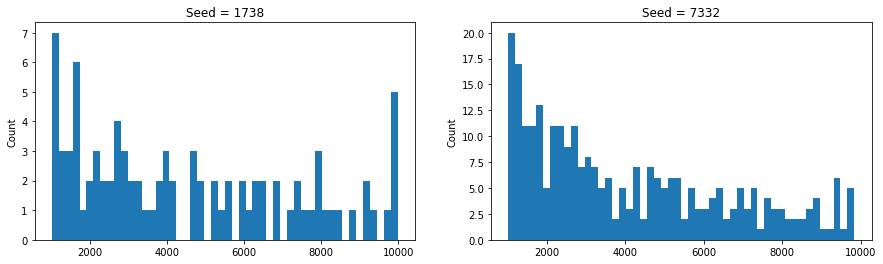

In [103]:
rng_1 = [x for x in middle_square(1738)]
rng_2 = [x for x in middle_square(7332)]

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].hist(rng_1, bins=50)
ax[0].set_title('Seed = 1738')
ax[0].set_ylabel('Count')
ax[1].hist(rng_2, bins=50)
ax[1].set_title('Seed = 7332')
ax[1].set_ylabel('Count')
plt.show()

The numbers do not seem to converge to a uniform distribution. And the periods are not large enough.

In [104]:
print('First RNG period', len(rng_1))
print('Second RNG period', len(rng_2))

First RNG period 89
Second RNG period 279


### 2) Linear Congruential Generator

This is a more robust random number generator and it works by taking the "seed" multiplying it by sum number `a`, adding some other number `c`, and finally taking modulus or remainder against `m`. The formula works like this:

$$
X_{n+1} = \left ( a \cdot X_{n} + c \right ) \mod{m}
$$

The great thing here is that the modulus defines the upper limit and this generates far more numbers than the previous algorithm. We can simply divide it by the largest number (m - 1) to normalize it to the interval of [0, 1]

In [107]:
def lcg(seed=4321, m=7829, a=378, c=2310):
    running_val = seed
    nums = set()
    while running_val not in nums:
        nums.add(running_val)
        running_val = (running_val * a + c) % m
        yield running_val / (m - 1)

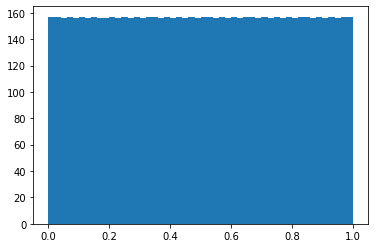

In [106]:
uniform_random_samples = [num for num in lcg()]
plt.hist(uniform_random_samples, bins=50)
plt.show()

Now we have written an algorithm that generates a uniform random distribution $\in [0, 1]$

---

### Inverse Transform Sampling

This trick relies on the inverse of the cumulative distribution function $\text{CDF}^{-1}$ so it maps the numbers from the uniform output as the values that the CDF is associated with.

For simplicity's sake, let us take the following PDF which will represent a form of logistic distribution.

The given PDF is:

$f(x) = \frac{e^{-x}}{(1 + e^{-x})^2}$

Which makes the CDF:

$F(x) = \int{f\; dx} = \frac{1}{1 + e^{-x}}$

And thus:

$\text{CDF}^{-1} = -\ln{ \left ( \frac{1}{x} - 1 \right )}$


In [108]:
def dist_samples(inverse_cdf=None, seed=4321, m=7829, a=378, c=2310):
    running_val = seed
    nums = set()
    while running_val not in nums:
        nums.add(running_val)
        running_val = (running_val * a + c) % m
        if callable(inverse_cdf):
            yield inverse_cdf(running_val / (m - 1))
        else:
            yield running_val / (m - 1)

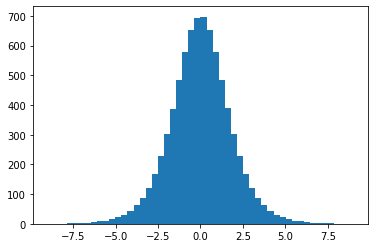

In [109]:
inverse_logistic = lambda x: -log(1 / x - 1) if (0 < x < 1) else 0

logistic_random_samples = [x for x in dist_samples(inverse_cdf=inverse_logistic)]
plt.hist(logistic_random_samples, bins=50)
plt.show()

And thus, we have a random logistic distribution, which resembles a Gaussian distribution. The reason I avoided the Gaussian is because it involves the inverse error function since that is the CDF of the Gaussian PDF.

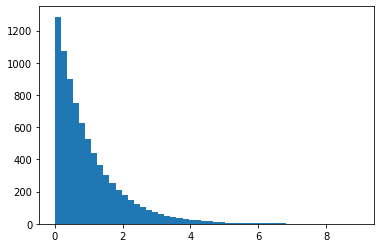

In [110]:
inverse_exp = lambda x: -log(x) if (0 < x < 1) else 0

exp_random_samples = [x for x in dist_samples(inverse_cdf=inverse_exp)]
plt.hist(exp_random_samples, bins=50)
plt.show()

Modifications to the lambda function modifies the shape of the ending distribution.

If you really want to see a Gaussian distribution, you can import `erfinv` from `scipy` library. And just for fun, you can also assign a mean of 2 and a variance of 3 to get the shape below.

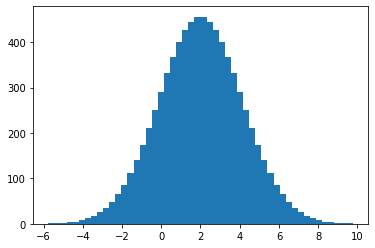

In [130]:
from scipy.special import erfinv

mu, s = 2, 3
inverse_gaussian = lambda x: mu + s * erfinv(2 * x - 1) if (0 < x < 1) else 0
gaussian_random_samples = [x for x in dist_samples(inverse_cdf=inverse_gaussian)]
plt.hist(gaussian_random_samples, bins=50)
plt.show()

To wrap up, now we have a way to generate random numbers that obey a uniform distribution using the Linear Congruential Generator, and them we were able to use the Inverse Transform Sampling to get other distributions.